# How to Develop a CNN for MNIST Handwritten Digit Classification
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from numpy import mean
from numpy import std
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
import keras
import keras.utils
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnistnpz/sample_image.pdf
/kaggle/input/mnistnpz/sample_image.png
/kaggle/input/mnistnpz/mnist.npz


### MNIST Handwritten Digit Classification Dataset

In [2]:
# load the data
def load_data(path):
    with np.load(path) as f:
        X_train, Y_train = f['x_train'], f['y_train']
        X_test, Y_test = f['x_test'], f['y_test']
        return (X_train, Y_train), (X_test, Y_test)
(trainX, trainY), (testX, testY) = load_data('../input/mnistnpz/mnist.npz')


Train: X=(60000, 28, 28), Y=(60000,)
Test: X=(10000, 28, 28), Y=(10000,)


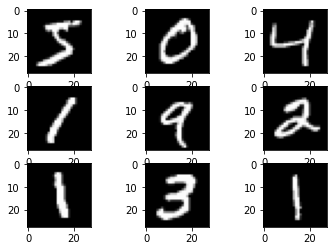

In [3]:
# summarize loaded dataset
print('Train: X=%s, Y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, Y=%s' % (testX.shape, testY.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

### Prepare Pixel Data
- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [4]:
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [5]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [6]:
trainX, testX = prep_pixels(trainX, testX)

### Define Model
- The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.
- For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.
- Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.
- All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.
- We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes

In [7]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = define_model()

In [9]:
# fit model
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
# save model
model.save('final_model.h5')

### Evaluate Model
- The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.
- The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.
- We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

In [10]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [11]:
scores, histories = evaluate_model(trainX, trainY)

> 99.033
> 99.125
> 98.992
> 99.133
> 99.133


### Present Results
- There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.
- First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.
- We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. 

In [12]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


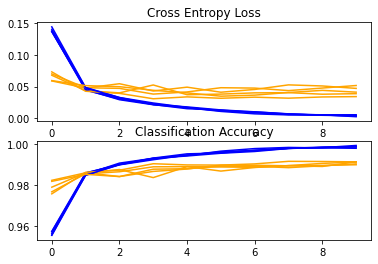

In [13]:
summarize_diagnostics(histories)

- Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. - -- This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

In [14]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

Accuracy: mean=99.083 std=0.059, n=5


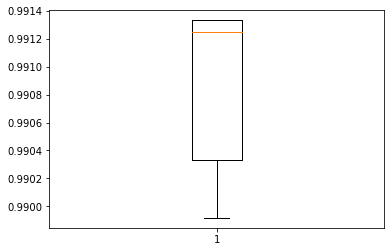

In [15]:
summarize_performance(scores)

In [16]:
# accuracy of the model achieved
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 99.250


### Make Prediction

In [19]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img
 
# load an image and predict the class
def run_example():
    # load the image
    img = load_image('/kaggle/input/mnistnpz/sample_image.png')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    digit = model.predict_classes(img)
    print(digit[0])
 
# entry point, run the example
run_example()

7


In [20]:
#End

NameError: name 'End' is not defined